# Identify atoms in the center and surface of the sample

**System**
* Alloy stoichiometry (ideal): $Al_{0.1}FeNiCrCo$
* Lattice: FCC
* Lattice constant: 3.57A

**APT measurement**
* Detector efficiency: 33%
* position uncertainty (standard deviation): 5A (in x-, y-directions) and 3A in z-direction

## Setup

In [1]:
# Notebook settings

# code development settings (automatically reload modified modules)
%load_ext autoreload
%autoreload 2

# plotting backend
%matplotlib inline

In [7]:
# basic libraries

import os, sys
import re
import copy
import glob
from itertools import product
import pickle
from collections import Counter
import numpy as np
#import scipy.io
from scipy.stats import multinomial, binom, chi2
from scipy.optimize import fmin
from sklearn.neighbors import NearestNeighbors

# plotting
import matplotlib.pyplot as plt

# data handling
# import pyUSID as usid
# import h5py
# import pandas as pd
# import xarray as xr

# parallelization
# from subprocess import Popen, PIPE
import multiprocessing as mp

In [8]:
# local library
sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_mc, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt, cfg_replicate
from statmechlib.forcefields import sd2

In [9]:
# project directories
data_raw = '../data/raw'
src_dir = '../src/utils'
sim_dir = '../sim/enth_model'

In [10]:
sys.path.append(src_dir)
from utils import *

## Distribution of cluster sizes

In [11]:
distances = np.loadtxt(os.path.join(data_raw, 'RamaTest_Clean_AllKthDistance'))
distances.shape

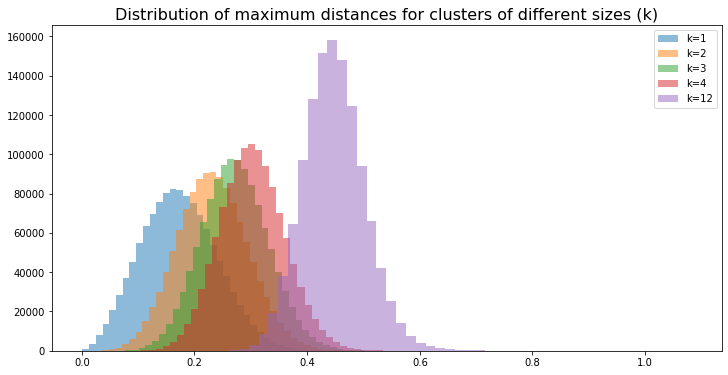

In [25]:
plt.figure(figsize=(12,6))
plt.title('Distribution of maximum distances for clusters of different sizes (k)', fontsize=16)
_ = plt.hist(distances[:,3], 50, alpha=0.5, label='k=1')
_ = plt.hist(distances[:,4], 50, alpha=0.5, label='k=2')
_ = plt.hist(distances[:,5], 50, alpha=0.5, label='k=3')
_ = plt.hist(distances[:,6], 50, alpha=0.5, label='k=4')
_ = plt.hist(distances[:,-1], 50, alpha=0.5, label='k=12')
plt.legend()

In [18]:
np.max(distances[:,-1]), np.min(distances[:,-1])

(1.08161, 0.208947)

## Sample density 2D profiles

In [28]:
xyzs = distances[:,:3]

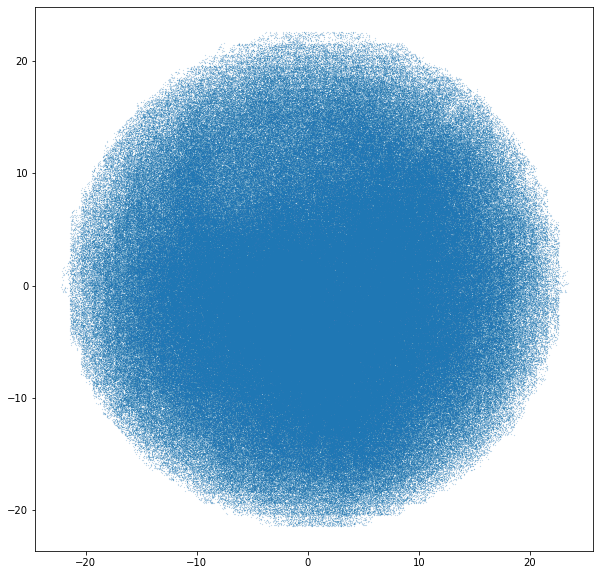

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(xyzs[:, 0], xyzs[:, 1], s=0.01)

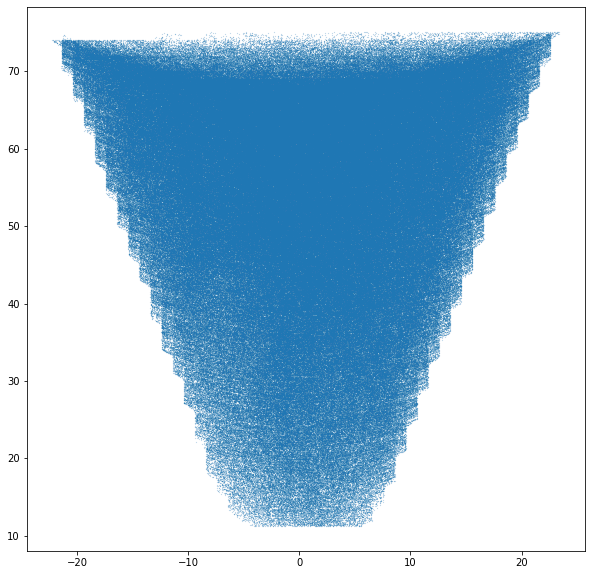

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(xyzs[:, 0], xyzs[:, 2], s=0.01)

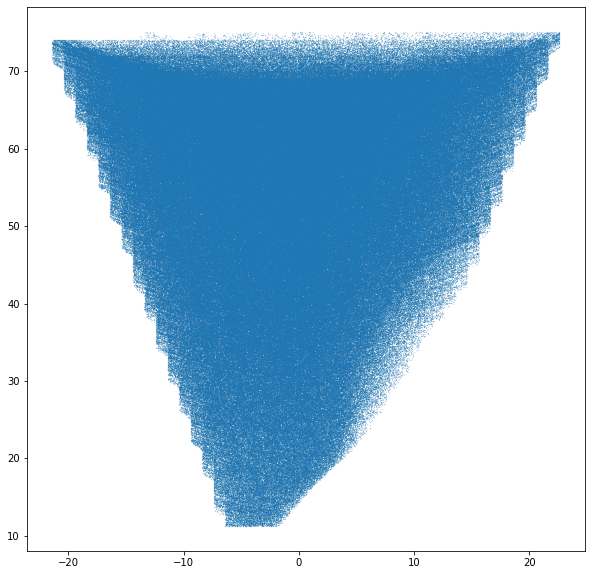

In [32]:
plt.figure(figsize=(10,10))
plt.scatter(xyzs[:, 1], xyzs[:, 2], s=0.01)

## Identify inner and surface atoms for the calculation of cluster statistics

1. Divide box into cells and assign the number of particles inside
2. Plot density statistics 

In [37]:
box_lim = np.empty((3,2), dtype=float)
box_lim[0,0] = xyzs[:,0].min()
box_lim[0,1] = xyzs[:,0].max()
box_lim[1,0] = xyzs[:,1].min()
box_lim[1,1] = xyzs[:,1].max()
box_lim[2,0] = xyzs[:,2].min()
box_lim[2,1] = xyzs[:,2].max()
box_lim

array([[-22.2471,  23.4146],
       [-21.3981,  22.599 ],
       [ 11.2416,  75.0933]])

In [49]:
# Create cell array
dL = np.int_(np.ceil(box_lim[:,1] - box_lim[:,0]))
print(dL)
print(dL[0]*dL[1]*dL[2])
cells = np.zeros(tuple(dL), dtype=int)

[46 44 64]
129536


In [57]:
# cycle through atoms and assign them to cells
for xyz in xyzs:
    pos = xyz - box_lim[:,0]
    ix, iy, iz = np.int_(np.floor(pos))
    cells[ix, iy, iz] += 1
    #print(ix, iy, iz)

(0, 2200)

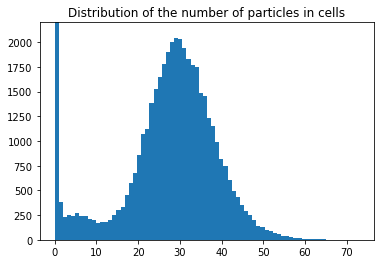

In [74]:
plt.title('Distribution of the number of particles in cells')
counts, _, _ = plt.hist(cells.flatten(), bins=(cells.max()+1))
#plt.xlim(1,)
plt.ylim(0,2200)

In [150]:
# coordinates of the low density cells
lowdens = np.where(cells < 10)
[len(x) for x in lowdens]

[90294, 90294, 90294]

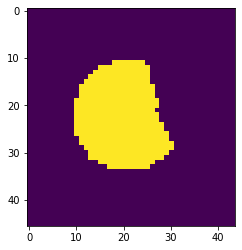

In [156]:
# matrix of the high density cells (yellow)
high_cells = cells >= 10
plt.imshow(high_cells[:,:,20])

In [157]:
# cycle over atoms and keep only those in higher density cells
xyzs_bulk = []
index_bulk = []
for xyz in xyzs:
    pos = xyz - box_lim[:,0]
    ix, iy, iz = np.int_(np.floor(pos))
    if high_cells[ix, iy, iz]:
        xyzs_bulk.append(xyz)
        index_bulk.append(True)
    else:
        index_bulk.append(False)

xyzs_bulk = np.array(xyzs_bulk)
index_bulk = np.array(index_bulk)

In [153]:
len(xyzs_bulk), len(xyzs), len(xyzs) - len(xyzs_bulk)

(1189652, 1200233, 10581)

## Collect KNN statistics

In [ ]:
knns = list(range(1,13))
#knns += [20, 40, 100, 200]

# 3. create nighbor model with the maximum of nearest neighbors (1000). KDTree should make this Nlog(N)
neigh = NearestNeighbors(n_neighbors=knns[-1], algorithm='kd_tree', n_jobs=-1)

## Read KNN statistics

In [158]:
# compositions, concentrations, atom types
element = ['Al','Fe','Ni','Cr','Co']
ntype = len(element)

# numbers of KNNs of a particular atom i of type ti
knn = list(range(1,13))
#knn += [20, 40, 100, 200, 500, 1000]

In [159]:
# functions to read data files with pairwise statistics

def read_pairwise(file_name, nn, ntype):
    """
    Parameters
    ----------
    file_name: str
        Input file with pairwise statistics
    nn: int
        number of nearest neighbors
    ntype: number of atom types
    
    Returns
    -------
    stats: ndarray(ntype, ntype, nn)
        all pairwise statistics for all atom types
    """
    
    # output array
    stats = np.zeros((ntype, ntype, nn+1), dtype=int)
    
    # regex to extract particle types
    atom_info = re.compile(r'IonType\s*(\d+)\s*,\s*type\s*(\d+)\s+')
    
    with open(file_name, 'r') as fin:
        for line in iter(fin.readline, ''):
            m = atom_info.search(line)
            i, j = [int(c) for c in m.groups()]

            counts = re.findall('\d+', fin.readline())
            stats[i, j, :] = [int(c) for c in counts]

    return stats

In [160]:
targets = {}
for k in knn:
    targets[k] = read_pairwise(os.path.join(data_raw, f'RamaTest_Clean_PatternK{k}_PairWise'), k, ntype)

In [167]:
# count statistics and concentrations
counts = np.sum(targets[knn[5]], axis=2)[:,0]
assert np.array_equal(counts, np.sum(targets[knn[0]], axis=2)[:,0])

conc = counts/np.sum(counts)

tot_counts = np.sum(counts)

In [168]:
tot_counts, counts, conc

(1200233,
 array([ 30699, 300950, 300909, 280969, 286706]),
 array([0.02557753, 0.25074298, 0.25070882, 0.23409538, 0.23887529]))

In [71]:
# same counts from 2D profiles
[int(np.sum(data[dat])) for dat in data_id]

[30699, 300950, 300909, 280969, 286706, 1200233, 120556]

## Generate random distributions (null hypothesis)

* Assume that there are no interactioins between particles and for each KNN generate multinomial distributions with parameters (probabilities) set to mole fractions.

In [72]:
def get_binomials(k, probs):

    probs_null = np.zeros((ntype, ntype, k+1), dtype=float)

    # marginal distributions for selected atoms (equivalent to binomial distributions)
    for it in range(ntype):
        for jt in range(ntype):
            bn = binom(n=k, p=probs[jt])
            pmf_bn = probs[it]*bn.pmf(range(k+1))
            probs_null[it, jt, :] = pmf_bn
            #print(k, it, jt, pmf_bn)

    return probs_null

In [184]:
null_reference = {}
null_counts = {}
for k in knn:
    null_reference[k] = get_binomials(k, conc)
    null_counts[k] = null_reference[k]*tot_counts*1134153.0/300950

## Convolute simulation data

In [74]:
def latt_to_real_coords(trj, scale=1.0):

    """
    Read xyz file with lattice coordinates
    and return rescaled atomic configurations in real units and (orthogonal) box dimensions.
    """
    
    boxs = []
    xyzs = []
    for box, xyz in zip(trj['box_latt'], trj['xyz_latt']):
        boxs.append(box*scale)
        xyzs.append(xyz*scale)
        # scale to fractional coordinates
        xyzs[-1] /= np.diag(boxs[-1])
    trj['box'] = boxs
    trj['xyz'] = xyzs
    return trj

In [93]:
def add_experimental_noise(trj, detect_rate=0.0, disp=[0.0, 0.0, 0.0], unknown_frac=0.0):
    """
    Apply random noise emulating APT experiment.
    Includes detector efficiency (only 33% retained) and random displacement.
    
    Parameters
    ----------
    xyz_in: list of ndarrays
        list of atom coordinates
    box: ndarray (3x3)
        box dimensions
    loss_rate: float or list of floats
        loss rate, overall (float) or per atom type (list)
    disp: array-like, shape(3)
        random displacement of atoms in x, y, z directions
        standard deviation of a Gaussian distribution
        
    Returns
    -------
    config_out: ndarray
        list of atoms and their coordinates in xyz format (type, x)
    """    
    
    xyzs = trj['xyz']
    boxs = trj['box']
    typs = trj['atom_type']

    xyzs_mod = []
    typs_mod = []

    for xyz, box, typ in zip(xyzs, boxs, typs):
        
        boxv = np.diag(box)

        xyz_mod = []
        typ_mod = []
        
        # select detection rate for the present box
        if isinstance(detect_rate, float):
            d_rate = detect_rate
        else:
            detected, dist_inv = detect_rate
            d_rate = detected[np.random.choice(dist_inv)]
    
        #print(d_rate)

        for r, t in zip(xyz, typ):
        
            # Step 1: remove a given fraction of particles
            if np.random.random() > d_rate:
                continue
            
            # Step 2: displace atoms using Gaussian noise
            rr = boxv*r
            rr += np.array([np.random.normal(loc=0.0, scale=disp[i]) for i in range(3)])

            # adjust positions using periodic boundary conditions
            rr = np.where(rr < 0.0, rr+boxv, rr)
            rr = np.where(rr > boxv, rr-boxv, rr)
            
            rr /= boxv
                
            xyz_mod.append(rr)
            
            # unknown type (type==6)
            if np.random.random() < unknown_frac:
                typ_mod.append(6)
            else:
                typ_mod.append(t)

                
        xyzs_mod.append(np.array(xyz_mod))
        typs_mod.append(np.array(typ_mod))


    return xyzs_mod, typs_mod

In [94]:
def real_coords(xyzs, boxs):
    xyzs_mod = []
    for xyz, box in zip(xyzs, boxs):
        boxv = np.diag(box)
        xyzs_mod.append(xyz*boxv)

    return xyzs_mod

In [95]:
def select_core(xyzs, boxs, tis):
    """
    Selects the central (core) region of a configuration with all coordinates
    closer to the center than surface.
    """
    
    xyzs_core = []    
    tis_core = []
    for xyz, box, ti in zip(xyzs, boxs, tis):

        bv = np.diag(box)
    
        r_core = []
        t_core = []
        for r, t in zip(xyz, ti):
            if r[0]<0.25*bv[0] or r[1]<0.25*bv[1] or r[2]<0.25*bv[2]:
                continue
            if r[0]>=0.75*bv[0] or r[1]>=0.75*bv[1] or r[2]>=0.75*bv[2]:
                continue

            r_core.append(r)
            t_core.append(t)
            
        xyzs_core.append(np.array(r_core))
        tis_core.append(np.array(t_core))

    return xyzs_core, tis_core

In [430]:
# read in a set of trajectories
#trj_dirs = ['txinf', 'tx500', 'tx700', 'tx1000']
#trj_dirs = ['txinf']
trj_dirs = ['6x700']

#trj_dirs = ['3x700']
sim_dir_m1 = '../sim/m1'
sim_dir_m2 = '../sim/m2'
sim_dir_m3 = '../sim/m3'
sim_dir_m4 = '../sim/m4'
sim_dir_m5 = '../sim/m5'
sim_dir_m6 = '../sim/m6'

In [431]:
#trjs = {}
for key in trj_dirs:
    # read trajectory info
    trjs[key] = read_lattice_mc(os.path.join(sim_dir_m6, key), verbose=1)

Reading ../sim/m6/6x700/lg.hst
Reading ../sim/m6/6x700/lg.run
Reading ../sim/m6/6x700/lg.xyz
Reading ../sim/m6/6x700/lg.mld


## Add experimental noise

In [432]:
unknown_frac = counts[-1]/np.sum(counts)

# analyze configurations
for key, trj in trjs.items():
    if key not in ['6x700']:
        continue
    print('trj:', key)

    # convert from lattice to real coordinates
    trj = latt_to_real_coords(trj, 3.57/2.0)

    # model of experimental noise
    xyzs, typs = add_experimental_noise(trj, detect_rate=(detected, dist_inv), disp=np.array([5.0, 5.0, 3.0]), unknown_frac=0.0)
    #xyzs, typs = add_experimental_noise(trj, loss_rate=0.0, disp=np.array([0.0, 0.0, 0.0]), unknown_frac=unknown_frac)
    trjs[key]['xyz_noise'] = xyzs
    trjs[key]['atom_type_noise'] = typs

trj: 6x700


In [433]:
#[(k, v[0:5]) for k, v in trjs['tx700'].items()]

In [434]:
# 1. replicate configurations to avoid dealing with periodic boundary conditions
# 2. convert to real coordinates
# 3. select core
for key, trj in trjs.items():
    if key not in ['6x700']:
        continue

    print('trj:', key)
    xyzs = []
    boxs = []
    tis = []
    for xyz, box, ti in zip(trj['xyz_noise'], trj['box'], trj['atom_type_noise']):
        xyz_big, box_big = cfg_replicate(xyz, box, vec_a=2, vec_b=2, vec_c=2)
        xyzs.append(xyz_big)
        boxs.append(box_big)
        tis.append(np.tile(ti, 2*2*2))                                          

    trj['xyz_noise'] = xyzs
    trj['box_noise'] = boxs
    trj['atom_type_noise'] = tis
    
    trj['xyz_noise'] = real_coords(trj['xyz_noise'], trj['box_noise'])
    
    trj['xyz_core'], trj['atom_type_core'] = select_core(trj['xyz_noise'], trj['box_noise'], trj['atom_type_noise'])

trj: 6x700


In [435]:
# with open('../data/interim/trjs.pickle', 'wb') as fo:
#     pickle.dump(trjs, fo)

### Neighbor statistics

In [436]:
knns = list(range(1,13))
#knns += [20, 40, 100, 200]

# 3. create nighbor model with the maximum of nearest neighbors (1000). KDTree should make this Nlog(N)
neigh = NearestNeighbors(n_neighbors=knns[-1], algorithm='kd_tree', n_jobs=-1)

In [437]:
def get_knn_stats(indices, ti_core, ti, knns=[], ntype=2):
    """
    Returns
    -------
        Atom-atom statistics for a given configuration
    """
    
    #ntype = max(list(Counter(ti).keys()) + list(Counter(ti_core).keys()))

    k_stats = []
    for k in knns:
        hst = np.zeros((ntype, ntype, k+1), dtype=int)
        
        for i, ind in enumerate(indices):
            nbr_dict = Counter(ti[ind[1:k+1]])
            for t in range(1, ntype+1):
                c = nbr_dict.get(t, 0)
                hst[ti_core[i]-1, t-1, c] += 1
            
        k_stats.append(hst)
            
    return k_stats

In [481]:
for key, trj in trjs.items():
    if key not in ['6x700']:
        continue

    print('trj:', key)

    knn_stats = []
    for it, (cor, xyz, ti_core, ti) in enumerate(zip(trj['xyz_core'], trj['xyz_noise'], trj['atom_type_core'], trj['atom_type_noise'])):
        print(it, len(ti_core), len(ti))
        if it < 2000:
            continue
        neigh.fit(xyz)
        dist, ind = neigh.kneighbors(cor, n_neighbors=knns[-1]+1)
        assert np.array_equal(dist[:,0], np.zeros(dist.shape[0])), "First neighbor is not center"
        knn_stats.append(get_knn_stats(ind, ti_core, ti, knns=knns, ntype=ntype))

    trj['knn'] = knn_stats

In [439]:
# with open('../data/interim/trjs_knn.pickle', 'wb') as fo:
#     pickle.dump(trjs, fo)

In [440]:
knn_all = {}
ppp_all = {}
conc_all = []

for key in ['tx700', 'txinf','3x700','4x700','5x700','6x700']:
    hists = trjs[key]['knn']
    #print(len(hists), len(hists[0]), hists[0][0].shape)
    
    # sum histograms
    print(key)
    knn_trj = []
    ppp_trj = []
    for i, k in enumerate(knns):
        hhh = np.zeros((ntype, ntype, k+1), dtype=float)
        for hst in hists:
            #print(hst[i].shape)
            hhh += hst[i]
        knn_trj.append(hhh)
        hsum = np.sum(hhh, axis=2)
        #print(i, hsum[:,0])
        if i == 0:
            counts_all = hsum[:,1]
            conc_all = counts_all/np.sum(counts_all)
        ppp = hhh/hsum[:,:,None]
        ppp_trj.append(ppp)
    
    knn_all[key] = knn_trj
    ppp_all[key] = ppp_trj
    # get probability distributions
tot_counts_all = np.sum(counts_all)
# print(conc_all, counts_all/10001, tot_counts_all)
# print(conc, counts, tot_counts)

tx700
txinf
3x700
4x700
5x700
6x700


## Compare distributions, statistical testing

In [457]:
def get_s2_two(key, targ, null, plot=True):
    """
    first normalizes the hypothesis to have the same counts as target
    """
        
    ntype = targ.shape[0]
    s2_all = 0.0
    df_all = 0.0
    for i in range(ntype):

        tt = np.array([sum([i*p for i, p in enumerate(targ[i,j,:])]) for j in range(ntype)])
        nn = np.array([sum([i*p for i, p in enumerate(null[i,j,:])]) for j in range(ntype)])
        
        n_nn = np.sum(nn)
        n_tt = np.sum(tt)
        
        #print(i, tt, nn/np.sum(nn)*np.sum(tt), np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))
        #print(i, np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))

        nn = nn/n_nn
        tt = tt/n_tt
        
        cb = sum([np.sqrt(t*n) for t, n in zip(tt, nn)])
        s2 = 4*n_nn*n_tt/(n_nn + n_tt)*np.arccos(cb)**2

        df = len(tt) - 1
        p_value = chi2.sf(s2, df)
        s2_all += s2
        df_all += df
        #print(key, i, 'p-value', p_value)
        #print(n_nn, n_tt)
    
    print(chi2.sf(s2_all, df_all))

In [467]:
print('P-values for different KNNs and models')
print('----------------------------')
print('KNN model  p-value')
print('----------------------------')
for i, k in enumerate(targets.keys()):
    if k > 200:
        continue
#     print(k, 'null ', end=' ')
#     get_s2_two(k, targets[k], null_counts[k])
    print(k, '  null  ', end=' ')
    get_s2_two(k, targets[k], knn_all['txinf'][i])
    print(k, '  enth  ', end=' ')
    get_s2_two(k, targets[k], knn_all['tx700'][i])
#     print('tx500')
#     get_s2_two(k, targets[k], knn_all['tx500'][i])
#     print('1x700')
#     get_s2_two(k, targets[k], knn_all['1x700'][i])
#     print(k, 'opti ', end=' ')
#     get_s2_two(k, targets[k], knn_all['3x700'][i])
#     print(k, 'new  ', end=' ')
#     get_s2_two(k, targets[k], knn_all['4x700'][i])
#     print(k, '5x   ', end=' ')
#    get_s2_two(k, targets[k], knn_all['5x700'][i])
    print(k, '  latest', end=' ')
    get_s2_two(k, targets[k], knn_all['6x700'][i])
    print('----------------------------')

P-values for different KNNs and models
----------------------------
KNN model  p-value
----------------------------
1   null   6.69447893352466e-05
1   enth   0.031610395078009106
1   latest 0.5233664291054224
----------------------------
2   null   1.5051719351371853e-09
2   enth   9.459999550364864e-05
2   latest 0.15158020795152996
----------------------------
3   null   4.398566374769331e-15
3   enth   3.978239877993083e-06
3   latest 0.017446247392089803
----------------------------
4   null   3.9334727604885676e-16
4   enth   8.465990991933774e-08
4   latest 0.011755996019106336
----------------------------
5   null   4.1321913387200154e-18
5   enth   1.758380353003596e-10
5   latest 0.010247716932877998
----------------------------
6   null   4.535788871242863e-20
6   enth   1.0624967283920789e-09
6   latest 0.08757102050252041
----------------------------
7   null   3.0124805661228083e-24
7   enth   2.683576848858873e-12
7   latest 0.322883410009546
----------------------------

In [476]:
def get_s2_all(key, targets, models, system):
    """
    first normalizes the hypothesis to have the same counts as target
    """
        
    s2_all = 0.0
    df_all = 0.0
    
    for ki, k in enumerate(targets):
        targ = targets[k]
        modl = models[system][ki]
        ntype = targ.shape[0]


        for i in range(ntype):

            tt = np.array([sum([i*p for i, p in enumerate(targ[i,j,:])]) for j in range(ntype)])
            nn = np.array([sum([i*p for i, p in enumerate(modl[i,j,:])]) for j in range(ntype)])
        
            n_nn = np.sum(nn)
            n_tt = np.sum(tt)
        
        #print(i, tt, nn/np.sum(nn)*np.sum(tt), np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))
        #print(i, np.array(tt) - np.array(nn)/np.sum(nn)*np.sum(tt))

            nn = nn/n_nn
            tt = tt/n_tt
        
            cb = sum([np.sqrt(t*n) for t, n in zip(tt, nn)])
            s2 = 4*n_nn*n_tt/(n_nn + n_tt)*np.arccos(cb)**2

            df = len(tt) - 1
            p_value = chi2.sf(s2, df)
            s2_all += s2
            df_all += df
        #print(key, i, 'p-value', p_value)
        #print(n_nn, n_tt)
    
    print(chi2.sf(s2_all, df_all))

In [480]:
print('P-values based on the full dataset (KNN=1-12) for different models')
print('----------------------------')
print('model  p-value')
print('----------------------------')

print('null  ', end=' ')
get_s2_all(k, targets, knn_all, 'txinf')
print('enth  ', end=' ')
get_s2_all(k, targets, knn_all, 'tx700')
#     print('tx500')
#     get_s2_two(k, targets[k], knn_all['tx500'][i])
#     print('1x700')
#     get_s2_two(k, targets[k], knn_all['1x700'][i])
#     print(k, 'opti ', end=' ')
#     get_s2_two(k, targets[k], knn_all['3x700'][i])
#     print(k, 'new  ', end=' ')
#     get_s2_two(k, targets[k], knn_all['4x700'][i])
#     print(k, '5x   ', end=' ')
#    get_s2_two(k, targets[k], knn_all['5x700'][i])
print('latest', end=' ')
get_s2_all(k, targets, knn_all, '6x700')
print('----------------------------')

P-values based on the full dataset (KNN=1-12) for different models
----------------------------
model  p-value
----------------------------
null   1.1396065475646438e-198
enth   2.673813180252164e-116
latest 1.14414568602291e-05
----------------------------


In [462]:
def get_ndiff(key, targ, null, plot=True):
    """
    first normalizes the hypothesis to have the same counts as target
    """
        
    ntype = targ.shape[0]

    t_counts = []
    r_counts = []
    for i in range(ntype):

        tt = np.array([sum([i*p for i, p in enumerate(targ[i,j,:])]) for j in range(ntype)])
        nn = np.array([sum([i*p for i, p in enumerate(null[i,j,:])]) for j in range(ntype)])
        
        n_nn = np.sum(nn)
        n_tt = np.sum(tt)
        
        t_counts.append(tt)
        r_counts.append(nn/np.sum(nn)*np.sum(tt))

    return np.float_(np.array(t_counts)), np.array(r_counts)

In [447]:
from scipy.optimize import fmin

In [448]:
def dn_loss(p, tt, rr):
    
    probmat = np.ones(tt.shape, dtype=float)
    rr_res = np.ones(tt.shape, dtype=float)

    ntype = probmat.shape[0]
    
    jj = 0
    for i in range(ntype):
        for j in range(i+1, ntype):
            probmat[i, j] = np.exp(-p[jj])
            probmat[j, i] = probmat[i, j]
            jj += 1
    
    for i in range(ntype):
        ncount = np.sum(rr[i,:])
        rr_res[i, :] = rr[i, :]*probmat[i,:]/ncount
        rr_res[i, :] /= np.sum(rr_res[i,:])
        rr_res[i, :] *= ncount

    #print(tt - rr_res)
    #print(rr)
    loss = np.sqrt(np.sum((np.sqrt(rr_res) - np.sqrt(tt))**2))
    #print(loss)
    #print(rr*probmat, tt)
    #print(p)
    return loss

In [449]:
def estimate_du(t_diff, r_diff):
    
    pars_in = np.zeros(10, dtype=float)
    output = fmin(dn_loss, pars_in, args=(t_diff, r_diff), maxiter=10000)#, disp=False)
    
    
    probmat = np.ones(t_diff.shape, dtype=float)
    rr_res = np.ones(t_diff.shape, dtype=float)

    ntype = probmat.shape[0]
    p = output
    #print('params', output)
    jj = 0
    for i in range(ntype):
        for j in range(i+1, ntype):
            probmat[i, j] = np.exp(-p[jj])
            probmat[j, i] = probmat[i, j]
            jj += 1

    for i in range(ntype):
        ncount = np.sum(r_diff[i,:])
        rr_res[i, :] = r_diff[i, :]*probmat[i,:]/ncount
        rr_res[i, :] /= np.sum(rr_res[i,:])
        rr_res[i, :] *= ncount

    #print(t_diff - rr_res)
    #print(rr)
    
    output *= 700/12
    print(output)
    #print(np.sum(t_diff), np.sum(r_diff), np.sum(probmat), np.sum(r_diff*probmat))
    
    return output

In [451]:
for i, k in enumerate(targets.keys()):
    if k > 4:
        continue
    print(k, 'null ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['txinf'][i])
    #print(np.sum(t_diff), np.sum(r_diff))
    estimate_du(t_diff, r_diff)
    #print(t_diff - r_diff)
    #print(t_diff.shape)
    print(k, 'enth ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['tx700'][i])
    estimate_du(t_diff, r_diff)

    #print(t_diff - r_diff)
    print(k, 'opti ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['3x700'][i])
    estimate_du(t_diff, r_diff)
    
    #print(t_diff - r_diff)
    print(k, 'new ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['4x700'][i])
    estimate_du(t_diff, r_diff)
    
    print(k, '5x  ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['5x700'][i])
    estimate_du(t_diff, r_diff)
    
    print(k, '6x  ')
    t_diff, r_diff = get_ndiff(k, targets[k], knn_all['6x700'][i])
    estimate_du(t_diff, r_diff)
    #print(t_diff - r_diff)
    print('----------------------------')

1 null 
Optimization terminated successfully.
         Current function value: 2.115953
         Iterations: 663
         Function evaluations: 924
[ 0.11183956 -2.86105686  0.90347304 -0.38500816 -0.15474735 -0.60547999
 -0.08802586  0.06113923 -0.18749051 -0.23837557]
1 enth 
Optimization terminated successfully.
         Current function value: 1.743827
         Iterations: 1283
         Function evaluations: 1805
[ 0.03192931 -2.16897572  0.06473757  0.23876657 -0.02436427 -0.32397428
  0.09719367 -0.08934094 -0.10565129 -0.53465627]
1 opti 
Optimization terminated successfully.
         Current function value: 1.545457
         Iterations: 851
         Function evaluations: 1173
[ 0.12134871 -1.87913088 -0.28419933 -0.85789158  0.02083504 -0.38429829
  0.13293174  0.14299853 -0.09479386 -0.36532216]
1 new 
Optimization terminated successfully.
         Current function value: 1.783618
         Iterations: 1046
         Function evaluations: 1437
[-0.03719047 -1.73866486 -0.3952834